In [1]:
import pandas as pd
import json

##collect slovak data
with open('/project/biocomplexity/UKR_forecast/migration_data/gtruth_from_various_source/slovak_border_movement.json', 'r') as file:
    data = json.load(file)

# Print the dataqu
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(1).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()
svk_ukr_depart_df = svk_ukr_depart_df.rename(columns={'data_date':'return_date','individuals':'departure'})

## collect romania data
rom_ukr_depart_df = pd.read_csv('romania_border_exit_ukr.csv')
rom_ukr_depart_df['return_date'] = pd.to_datetime(rom_ukr_depart_df['return_date'])
rom_ukr_depart_df.replace(',','', regex=True, inplace=True)
rom_ukr_depart_df['departure'] = rom_ukr_depart_df['departure'].apply(pd.to_numeric,errors='coerce')
rom_ukr_depart_df['departure'] = rom_ukr_depart_df['departure'].rolling(1).mean()
rom_ukr_depart_df = rom_ukr_depart_df.dropna(subset='departure')


In [2]:
%%time
import geopandas as gpd
import os
## get all simulation data

def get_refugee_file(raion_name,sim_idx):
    refugee_file_name = f'mim_hid_completed_{raion_name}_{sim_idx}.csv'
    refugee_file_name_fast = f'mim_hid_completed_{raion_name}_{sim_idx}.pq'
    hid_status_file = OUTPUT_DIR+refugee_file_name
    hid_status_file_fast = OUTPUT_DIR+refugee_file_name_fast
    if os.path.isfile(hid_status_file_fast):
        df_hid = pd.read_parquet(hid_status_file_fast)
    else:
        df_hid = pd.read_csv(hid_status_file)
        df_hid.to_parquet(hid_status_file_fast,index=False)
    df_hid = df_hid[['hid','prob_conflict','OLD_PERSON','CHILD','ADULT_MALE','ADULT_FEMALE','rlid','h_lat','h_lng',
                     'N_size','P(move|violence)','moves','move_type','move_date']]
    df_refugee = df_hid[df_hid.move_type==2]
    #print(df_hid.shape[0],'displaced from MIM simulation')
    #print(df_refugee.shape[0],'refugees from MIM simulation')
    return df_refugee

def load_intention_df(all_raions):
    good_sims = [5,6,7,9,11,12,14,19,21,23,26,29,39,40,43,45,46,48,49,50,51,53,54,63,67,78,86,87,98]
    #good_sims = [5]
    intention_sim = []

    for sim in good_sims:
        print(sim)
        all_dfs = []

        for raion in all_raions:
            #if raion!='Kyiv':
            #    continue
            #if raion=='Kyiv':
                #print(len(all_dfs))
            #print(raion)
            try:
                df_refugee = get_refugee_file(raion,str(sim).zfill(9))
                df_refugee['h_size'] = df_refugee[DEMO_TYPES].sum(axis=1)
                df_refugee['move_date'] = pd.to_datetime(df_refugee['move_date'])
                aggdf_refugee = df_refugee.groupby('move_date')['h_size'].sum().reset_index()
                all_dfs.append(aggdf_refugee)
            except:
                continue

        int_df = (pd.concat(all_dfs)).groupby('move_date')['h_size'].sum().reset_index()
        int_df['simidx'] = sim
        intention_sim.append(int_df)
    return intention_sim

# geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
# ukr_gdf = gpd.read_file(geo_shp_file)
# all_raions = ukr_gdf['ADM2_EN'].tolist()
# print('regions read..',flush=True)
# intention_sim = load_intention_df(all_raions)

CPU times: user 38 ms, sys: 31.1 ms, total: 69 ms
Wall time: 1.43 s


In [3]:
# avg_migration_df = (((pd.concat(intention_sim)).pivot(index='move_date',columns='simidx',values='h_size')).mean(axis=1)).reset_index()

In [4]:
# avg_migration_df = avg_migration_df.rename(columns={0:'migrants'})

In [5]:
# avg_migration_df.to_csv('llm_datasets/input/avg_migration_context.csv',index=False)

In [6]:
from file_paths_and_consts import *

def get_conflict_context(start_date, end_date, get_placeholder=True):
    USE_NEIGHBOR = 5
    CONFLICT_DATA_PREFIX = 'ukraine_conflict_data_ADM2_HDX_buffer_'
    NEIGHBOR_DATA_PREFIX = 'ukraine_neighbor_'
    NETWORK_TYPE = '_R_0.01_P_0.04_Q_8_al_2.3.csv'
    NETWORK_TYPE_fast = '_R_0.01_P_0.04_Q_8_al_2.3.pq'
    
    total_impact_data = pd.read_csv(IMPACT_DIR+CONFLICT_DATA_PREFIX+str(USE_NEIGHBOR)+'_km.csv')
    total_impact_data['time'] = pd.to_datetime(total_impact_data['time'])

    conflict_context_1 = total_impact_data.groupby('time')['event_intensity'].sum().reset_index()
    conflict_context_1 = conflict_context_1.rename(columns={'event_intensity':'conflict_fatality'})
    
    conflict_context_2 = total_impact_data.groupby('time')['event_intensity'].count().reset_index()
    conflict_context_2 = conflict_context_2.rename(columns={'event_intensity':'conflict_count'})

    conflict_context = conflict_context_1.merge(conflict_context_2,on='time',how='inner')
    conflict_context = conflict_context[conflict_context.time>=pd.to_datetime(start_date)]
    conflict_context = conflict_context[conflict_context.time<=pd.to_datetime(end_date)]

    conflict_count_string = ', '.join(map(str, conflict_context['conflict_count']))
    conflict_intensity_string = ', '.join(map(str, conflict_context['conflict_fatality']))
    
    conflict_context_string_1 = f"From {start_date} to {end_date}, the number of recorded event was {conflict_count_string} each day"
    conflict_context_string_2 = f"From {start_date} to {end_date}, the number of total fatalitiy from these events was {conflict_intensity_string} each day"
    # for idx,row in conflict_context.iterrows():
    #     print(row['time'],row['conflict_fatality'],row['conflict_count'])
    if get_placeholder:
        return f"From [CONFLICT_START_DATE] to [CONFLICT_END_DATE], the number of recorded event was [TIME_SERIES_DATA_A] each day"+f"From [CONFLICT_START_DATE] to [CONFLICT_END_DATE], the number of total fatalitiy from these events was [TIME_SERIES_DATA_A] each day"
    return conflict_context_string_1,'\n',conflict_context_string_2

def get_historical_context(ground_truth_data,start_date, end_date,dest,get_placeholder=True):
    
    cur_data = ground_truth_data[ground_truth_data.return_date>=pd.to_datetime(start_date)]
    cur_data = cur_data[cur_data.return_date<=pd.to_datetime(end_date)]

    history_string = ', '.join(map(str, cur_data['departure'].astype(int)))
    
    history_context_string = f"From {start_date} to {end_date}, the number of returnee from {dest} to Ukraine was {history_string} each day"
    if get_placeholder:
        return f"From [HISTORY_START_DATE] to [HISTORY_END_DATE], the number of returnee from [DEST] to Ukraine was [TIME_SERIES_DATA_C] each day"
    return history_context_string

def get_migration_context(start_date, end_date,get_placeholder=True):
    simulation_data = pd.read_csv('llm_datasets/input/avg_migration_context.csv')
    simulation_data['move_date'] = pd.to_datetime(simulation_data['move_date'])
    cur_data = simulation_data[simulation_data.move_date>=pd.to_datetime(start_date)]
    cur_data = cur_data[cur_data.move_date<=pd.to_datetime(end_date)]

    migration_string = ', '.join(map(str, cur_data['migrants'].astype(int)))
    
    migration_context_string = f"From {start_date} to {end_date}, the estimated average number of border crossings from Ukraine was {migration_string} each day"
    if get_placeholder:
        return f"From [MIGRATION_START_DATE] to [MIGRATION_END_DATE], the estimated average number of border crossings from Ukraine was [TIME_SERIES_DATA_D] each day"
    return migration_context_string

#print(get_conflict_context('2022-03-01','2022-08-01'))
#print(get_historical_context(svk_ukr_depart_df,'2022-03-01','2022-08-01','Slovakia'))
#print(get_migration_context('2022-03-01','2022-08-01'))

In [7]:
dest = "Slovakia"
historical_data = svk_ukr_depart_df
historical_context_start = '2022-03-17'
historical_context_end = '2022-05-01'

conflict_context_start = '2022-03-02'
conflict_context_end = '2022-08-01'

migration_context_start = '2022-03-02'
migration_context_end = '2022-08-01'

forecast_start = '2022-03-24'
forecast_end = '2022-08-01'

context_level_1 = "\nMigration Context: Daily Number of Border Crossing from Ukraine (To any country)"
lo_context = f"##Migration Context##\n {get_migration_context(migration_context_start,migration_context_end,get_placeholder=False)}\n\n"

context_level_2 = f"{context_level_1}\nConflict Context: Daily Number of Conflict events and fatalities in Ukraine"
mid_context = f"{lo_context}##Conflict Context##\n {get_conflict_context(conflict_context_start,conflict_context_end,get_placeholder=False)}\n\n"

context_level_3 = f"{context_level_1}{context_level_2}\nHistorical Context: Partial Ground Truth about number of returnees from {dest} to Ukraine"
full_context =  f"{mid_context}##Historical Context##\n {get_historical_context(historical_data,historical_context_start,historical_context_end,dest,get_placeholder=False)}\n\n"

chosen_context_level = context_level_2
chosen_context = full_context

constraint = f"YOU CANNOT SEARCH for any information regarding daily number of returnees online. However, you can search for other information (e.g., GDP of {dest}) if necessary. Other than that, you should only use your predictive capability and the data given to you."

role = f"""Imagine you are an expert forecaster. It is year 2022 and you are tasked with trying to estimate the number of return migrants from {dest} to Ukraine due to the Russian Invasion. You are given the following contexts: {chosen_context_level}\n {constraint} \n 

CONTEXT START\n\n
{chosen_context}
CONTEXT END\n\n"""

task = f"""Make forecast about the number of returnees from {dest} to Ukraine. The forecast needs to be provided in CSV format with the following columns: <time, estimated_returnee>. You have to generate them for each day between {forecast_start} and {forecast_end}\n

You should also explain your rationale behind the forecast, including any analytical form of the model you used to generate the numbers.\n\n"""


print(role)
print(task)

Imagine you are an expert forecaster. It is year 2022 and you are tasked with trying to estimate the number of return migrants from Slovakia to Ukraine due to the Russian Invasion. You are given the following contexts: 
Migration Context: Daily Number of Border Crossing from Ukraine (To any country)
Conflict Context: Daily Number of Conflict events and fatalities in Ukraine
 YOU CANNOT SEARCH for any information regarding daily number of returnees online. However, you can search for other information (e.g., GDP of Slovakia) if necessary. Other than that, you should only use your predictive capability and the data given to you. 
 

CONTEXT START


##Migration Context##
 From 2022-03-02 to 2022-08-01, the estimated average number of border crossings from Ukraine was 189196, 191870, 201993, 176462, 165995, 164690, 142435, 152534, 129194, 120893, 141482, 113838, 107187, 130498, 108001, 116562, 100351, 104209, 82411, 67261, 67083, 69999, 53350, 74871, 70110, 68476, 56113, 49014, 68558, 5268

chatgpt with full context 0.21249631721842235 0.09259801475038967 0.8008479369832233
chatgpt with mid context 1.4516728489725583 0.4880143230706235 -0.8658308798422933
#######################################
claude with full context 0.6176079688612771 0.16551326825637647 0.7326922062865682
claude with mid context 1.0398987907907813 0.3929121098068891 0.5684888927982532
#######################################
gemini with full context 0.17221221334771378 0.0561579163757371 0.7016531465259626
gemini with mid context 0.7963358845484292 0.29837516081509236 -0.17655314334248245
#######################################


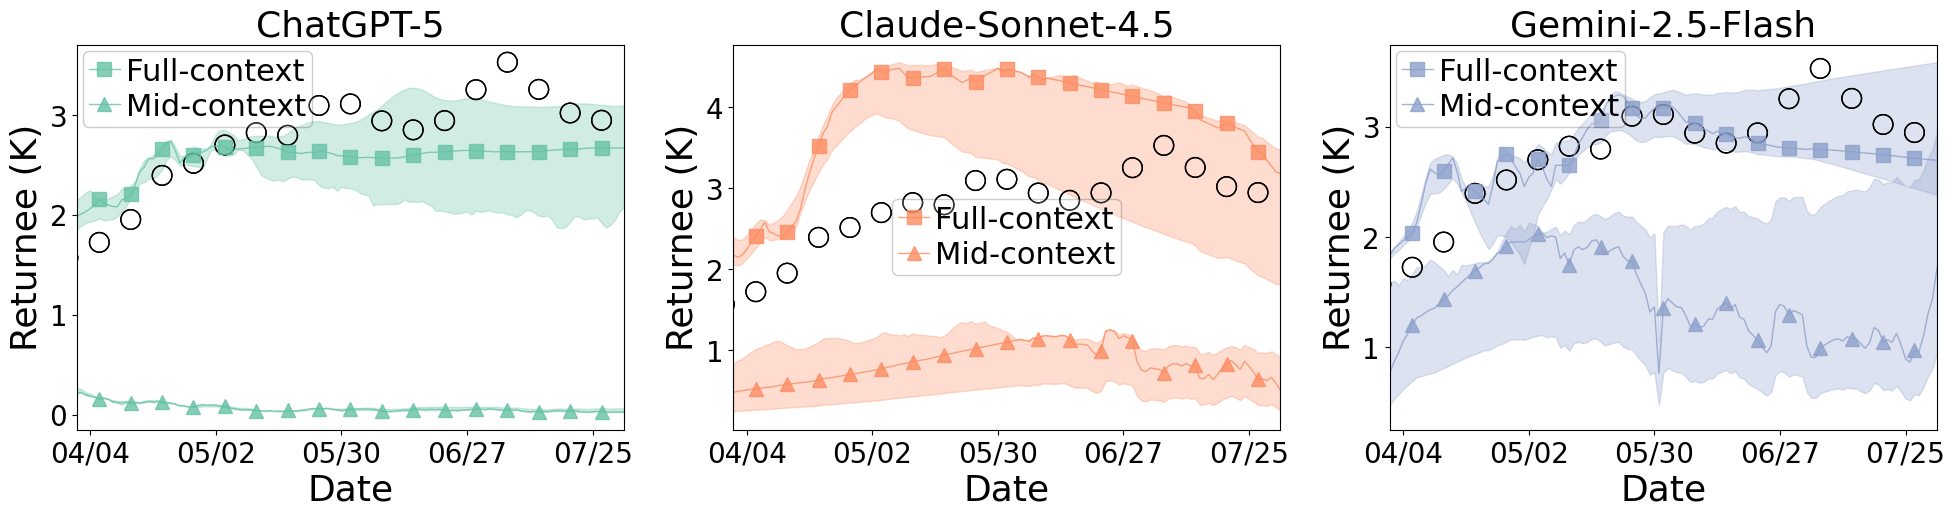

In [3]:
import matplotlib.pyplot as plt
from utils import calculate_normalized_metrics

from matplotlib import rcParams

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

def plot_sim_and_gt_SGT(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                        not_plot_gt=0,coverage=0.5,ymax=35,base_color = '#d95f0e',marker='^'):
    #print('visualization for',model_name)
    
    cover_alpha_dict = {0.5:0.3,0.9:0.2,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3

    title = model_name.split(':')[0]
    model_name = model_name.split(':')[1]
    
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    #ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    
    ax.plot(sim_df['return_date'],sim_df['median']/1000,alpha=0.8/top_k,color=base_color,linewidth=1,label=f'{model_name}-context',marker=marker,markevery=7,markersize=10)
    
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
            
    #ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    ax.set_title(title)
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)

def get_full_ensemble(llm,context,dest='Slovakia',smooth=7):

    file_path = f'llm_datasets/output/{context}/{llm}/{dest}/'
    
    all_llm_dfs = []
    
    idx = 0
    
    for f in os.listdir(file_path):
        if f.endswith('csv'):
            df = pd.read_csv(f'{file_path}{f}')
            df['run_index'] = idx
            idx = idx+1
            df['estimated_returnee'] = df['estimated_returnee'].rolling(smooth).mean()
            df = df.dropna(subset=['estimated_returnee'])
            #print(df.columns.tolist())
            all_llm_dfs.append(df)
    ensemble_df = ((pd.concat(all_llm_dfs)).pivot(index='time',columns='run_index',values='estimated_returnee'))
    ensemble_df_median = (ensemble_df.quantile(q=0.5,axis=1)).reset_index()
    med = ensemble_df_median.rename(columns={0.5:'median'})
    ensemble_df_q1 = (ensemble_df.quantile(q=0.25,axis=1)).reset_index()
    q1 = ensemble_df_q1.rename(columns={0.25:'q1'})
    ensemble_df_q3 = (ensemble_df.quantile(q=0.75,axis=1)).reset_index()
    q3 = ensemble_df_q3.rename(columns={0.75:'q3'})
    full_ensemble = (med.merge(q1,on='time',how='inner')).merge(q3,on='time',how='inner')
    full_ensemble['time'] = pd.to_datetime(full_ensemble['time'])
    full_ensemble = full_ensemble.rename(columns={'time':'return_date'})
    return full_ensemble

def create_smoothed_merged_data(sim_df,gt_df,date_col):
    merged_df = sim_df.merge(gt_df,on=date_col,how='inner')
    return merged_df


# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(14).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()
svk_ukr_depart_df = svk_ukr_depart_df.rename(columns={'data_date':'return_date','individuals':'departure'})

fig,ax = plt.subplots(1,3,figsize=(24,5))
#ax.scatter(svk_ukr_depart_df[::7]['return_date'],svk_ukr_depart_df[::7]['departure'],label='Ground Truth')

model_name = 'chatgpt'
model_display_name = 'ChatGPT-5'
model_color = '#66c2a5'
axw = ax[0]
llm_ensemble = get_full_ensemble(model_name,'full_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')

model_name = 'claude'
model_display_name = 'Claude-Sonnet-4.5'
model_color = '#fc8d62'
axw = ax[1]
llm_ensemble = get_full_ensemble(model_name,'full_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')

model_name = 'gemini'
model_display_name = 'Gemini-2.5-Flash'
model_color = '#8da0cb'
axw = ax[2]
llm_ensemble = get_full_ensemble(model_name,'full_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')
#fig.savefig('Figures/llm-slovakia.png',dpi=350,bbox_inches='tight')


In [8]:
svk_ukr_depart_df[['return_date','departure']].to_csv('/project/biocomplexity/fa7sa/LLM_migration/dataset/slovakia_return_ground_truth.csv',index=False)

chatgpt with full context 0.21695351714468247 0.0726945670739474 0.6128331484276008
chatgpt with mid context 1.4204266028502135 0.4736849774952216 -0.8579808814489951
#######################################
claude with full context 1.0023853556746987 0.30385135292114046 -0.8637238893084229
claude with mid context 1.0490879684543923 0.37620074577545326 -0.7188081810112072
#######################################
gemini with full context 0.9112425765257688 0.3313665766807433 0.7691999616535559
gemini with mid context 0.6860203580066324 0.299202287650438 0.7808257094346795
#######################################


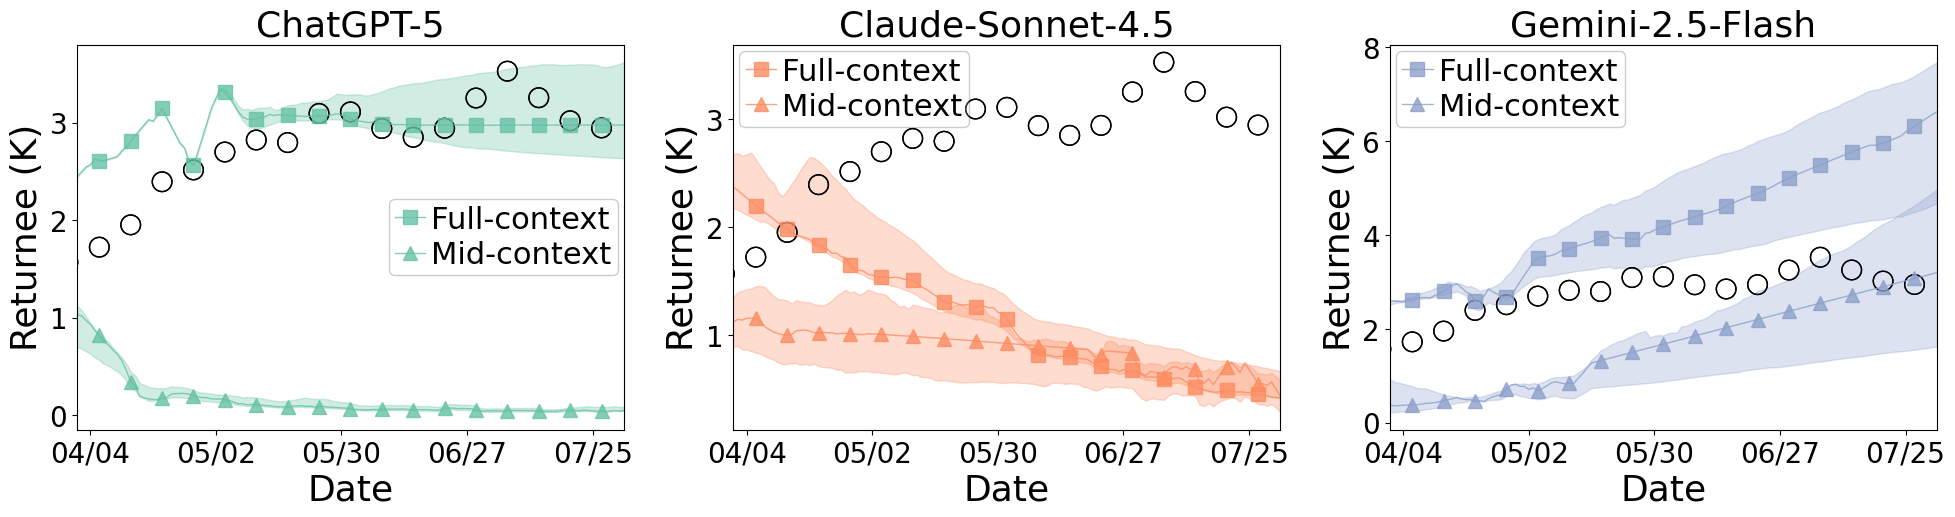

In [6]:
import matplotlib.pyplot as plt
from utils import calculate_normalized_metrics

from matplotlib import rcParams

max_font_size = 28
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-2
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-8
rcParams["ytick.labelsize"] = max_font_size-8


import matplotlib.dates as mdates
lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,
              'ecolor':'black','size':22,'alpha':0.2}

def scale_purifier(val,lb=0.95,rb=1.05):
    return max(lb,min(val,rb))

def plot_sim_and_gt_SGT(ax,sim_df,model_name,gt_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=0,
                    country_name='PL',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                        not_plot_gt=0,coverage=0.5,ymax=35,base_color = '#d95f0e',marker='^'):
    #print('visualization for',model_name)
    
    cover_alpha_dict = {0.5:0.3,0.9:0.2,0.95:0.2}
    alpha = cover_alpha_dict[coverage] if coverage in cover_alpha_dict else 0.3

    title = model_name.split(':')[0]
    model_name = model_name.split(':')[1]
    
    ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    #ax.fill_between(sim_df['return_date'],sim_df['q1']/1000,sim_df['q3']/1000,alpha=alpha/top_k,color=base_color)
    
    ax.plot(sim_df['return_date'],sim_df['median']/1000,alpha=0.8/top_k,color=base_color,linewidth=1,label=f'{model_name}-context',marker=marker,markevery=7,markersize=10)
    
    if not not_plot_gt:
        ax.scatter(gt_df['return_date'][::7],gt_df['departure'][::7]/(1000*gt_scale),facecolor='none',edgecolor='black',s=200)
    
    if conflict_data is not None:
        print('plotting conflict data')
        ax2 = ax.twinx()
        ax2.plot(conflict_context['time'],conflict_context['conflict'],label='C(t)',color='red')
            
    #ll,err,corr = compute_loss(sim_df, gt_df, 'departure',date_start,date_end,gt_scale=gt_scale)
    
    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0,interval=4))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim([pd.to_datetime(date_start),pd.to_datetime(date_end)])
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                 handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                 ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, 
                 prop={'size': lgd_params['size']})
    ax.set_ylabel('Returnee (K)')
    ax.set_title(title)
    ax.set_xlabel('Date')
    
    props = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **props)

def get_full_ensemble(llm,context,dest='Slovakia',smooth=7):

    file_path = f'llm_datasets/output/{context}/{llm}/{dest}/'
    
    all_llm_dfs = []
    
    idx = 0
    
    for f in os.listdir(file_path):
        if f.endswith('csv'):
            df = pd.read_csv(f'{file_path}{f}')
            df['run_index'] = idx
            idx = idx+1
            df['estimated_returnee'] = df['estimated_returnee'].rolling(smooth).mean()
            df = df.dropna(subset=['estimated_returnee'])
            #print(df.columns.tolist())
            all_llm_dfs.append(df)
    ensemble_df = ((pd.concat(all_llm_dfs)).pivot(index='time',columns='run_index',values='estimated_returnee'))
    ensemble_df_median = (ensemble_df.quantile(q=0.5,axis=1)).reset_index()
    med = ensemble_df_median.rename(columns={0.5:'median'})
    ensemble_df_q1 = (ensemble_df.quantile(q=0.25,axis=1)).reset_index()
    q1 = ensemble_df_q1.rename(columns={0.25:'q1'})
    ensemble_df_q3 = (ensemble_df.quantile(q=0.75,axis=1)).reset_index()
    q3 = ensemble_df_q3.rename(columns={0.75:'q3'})
    full_ensemble = (med.merge(q1,on='time',how='inner')).merge(q3,on='time',how='inner')
    full_ensemble['time'] = pd.to_datetime(full_ensemble['time'])
    full_ensemble = full_ensemble.rename(columns={'time':'return_date'})
    return full_ensemble

def create_smoothed_merged_data(sim_df,gt_df,date_col):
    merged_df = sim_df.merge(gt_df,on=date_col,how='inner')
    return merged_df


# Print the data
df = pd.DataFrame.from_dict(data['data']['timeseries'])
df['data_date'] = pd.to_datetime(df['data_date'])
df = df[df.data_date<=pd.to_datetime('2022-08-01')]
df['individuals'] = df['individuals'].rolling(14).mean()
df = df.dropna(subset='individuals')
svk_ukr_depart_df = df.copy()
svk_ukr_depart_df = svk_ukr_depart_df.rename(columns={'data_date':'return_date','individuals':'departure'})

fig,ax = plt.subplots(1,3,figsize=(24,5))
#ax.scatter(svk_ukr_depart_df[::7]['return_date'],svk_ukr_depart_df[::7]['departure'],label='Ground Truth')

model_name = 'chatgpt'
model_display_name = 'ChatGPT-5'
model_color = '#66c2a5'
axw = ax[0]
llm_ensemble = get_full_ensemble(model_name,'full_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')

model_name = 'claude'
model_display_name = 'Claude-Sonnet-4.5'
model_color = '#fc8d62'
axw = ax[1]
llm_ensemble = get_full_ensemble(model_name,'full_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')

model_name = 'gemini'
model_display_name = 'Gemini-2.5-Flash'
model_color = '#8da0cb'
axw = ax[2]
llm_ensemble = get_full_ensemble(model_name,'full_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Full',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='s')
print(f'{model_name} with full context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])

llm_ensemble = get_full_ensemble(model_name,'mid_context',dest='Romania')
llm_ensemble_with_gt = create_smoothed_merged_data(llm_ensemble,svk_ukr_depart_df,'return_date')
# ax.plot(chatgpt_ensemble['return_date'],chatgpt_ensemble['median'],label='chatgpt',color='blue')
# ax.fill_between(chatgpt_ensemble['return_date'],chatgpt_ensemble['q1'],chatgpt_ensemble['q3'],alpha=0.2,color='blue')
metric_dict = calculate_normalized_metrics(llm_ensemble_with_gt,date_col='return_date',date_start='2022-04-01',date_end='2022-08-01')
plot_sim_and_gt_SGT(axw,llm_ensemble,f'{model_display_name}:Mid',svk_ukr_depart_df,lgd_params,conflict_data=None,gt_scale=1,add_legend=1,
                    country_name='SVK',date_start='2022-04-01',date_end='2022-08-01',top_k=1,
                    not_plot_gt=0,coverage=0.5,ymax=35,base_color=model_color,marker='^')
print(f'{model_name} with mid context',metric_dict['normalized_rmse'],metric_dict['normalized_crps'],metric_dict['pearson_correlation'])
print('#######################################')
#fig.savefig('Figures/llm-romania.png',dpi=350,bbox_inches='tight')


In [9]:
rom_ukr_depart_df[['return_date','departure']].to_csv('/project/biocomplexity/fa7sa/LLM_migration/dataset/romania_return_ground_truth.csv',index=False)

In [9]:
metric_dict

{'normalized_interval_score': np.float64(0.3733366191263856),
 'normalized_crps': np.float64(0.09259801475038967),
 'normalized_quantile_score': np.float64(0.05187660132280829),
 'coverage_rate': np.float64(0.4796747967479675),
 'normalized_sharpness': np.float64(0.24912783352977563),
 'normalized_mae': np.float64(0.12459129837365691),
 'normalized_rmse': np.float64(0.21249631721842235),
 'normalized_bias': np.float64(-0.08198053665463952),
 'pearson_correlation': np.float64(0.8008479369832233),
 'below_q1_rate': np.float64(0.2032520325203252),
 'above_q3_rate': np.float64(0.3170731707317073),
 'n_observations': 123,
 'mean_observation': np.float64(2799.5087108013936),
 'raw_interval_score': np.float64(1045.1591173054587),
 'raw_crps': np.float64(259.22894889663183),
 'raw_mae': np.float64(348.79442508710804),
 'raw_rmse': np.float64(406.67241623094213),
 'raw_bias': np.float64(-229.50522648083626)}

In [53]:
ensemble_df['median'] = ensemble_df[[0,1,2]].quantile(q=0.5,axis=1)
ensemble_df['q1'] = ensemble_df[[0,1,2]].quantile(q=0.25)
ensemble_df['q3'] = ensemble_df[[0,1,2]].quantile(q=0.75)
ensemble_df

run_index,time,0,1,2,median,q1,q3
0,2022-03-24,2014,2012,1552,2630.0,2570.0,2663.5
1,2022-03-25,1632,1622,1646,1840.0,1468.5,2152.5
2,2022-03-26,1841,1834,1895,3323.0,2761.0,3573.0
3,2022-03-27,1822,1816,1780,NaN,NaN,NaN
4,2022-03-28,1983,1981,1582,NaN,NaN,NaN
...,...,...,...,...,...,...,...
126,2022-07-28,2668,1087,3526,NaN,NaN,NaN
127,2022-07-29,2668,1619,3486,NaN,NaN,NaN
128,2022-07-30,2669,1466,3485,NaN,NaN,NaN
129,2022-07-31,2671,2146,3595,NaN,NaN,NaN
